### Introduction to Preprocessing and Training Stage (Clay Court Version - First Round Analysis)

* Clay court (2012-2019) benchmark models for no first round matches

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_player_all_for_EDA.csv')
df.head()

,t_id,t_ident,t_nm,t_co,t_GMT_diff,t_surf,t_ind,t_alt,t_draw_sz,t_lvl,...,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
0,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.02,0.00,-0.02,0.00
1,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.02,0.00
2,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.01,0.01,0.00,0.01,-0.01,0.01,0.00,0.01,-0.01,0.00
3,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,0.01,-0.01,0.00,-0.01,0.01,-0.01,0.00,-0.01,0.01,0.00
4,20190605,91,Tour Finals,GBR,1,2,1,0,8,3,...,-0.03,-0.02,-0.05,-0.03,-0.03,-0.02,-0.05,-0.03,-0.04,-0.03


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57068 entries, 0 to 57067
Columns: 689 entries, t_id to p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
dtypes: float64(652), int64(30), object(7)
memory usage: 300.0+ MB


### Filter Data

See notebook Intro for details and justification. 

In [122]:
# Select Clay Court Surface matches only 
df_filter = df.loc[(df["t_surf"] == 1)]

In [123]:
# Select match year inclusion
df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015) | (df_filter["m_yr"] == 2014) | (df_filter["m_yr"] == 2013) | (df_filter["m_yr"] == 2012)]

In [6]:
# For all round but first round variant
# Remove first round matches
#df_filter = df_filter.loc[(df_filter["m_rd_num"] != 1)]

In [124]:
# For all round but first round variant
# Remove first round matches
df_filter = df_filter.loc[(df_filter["m_rd_num"] == 1)]

In [125]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted. 
df_low_pass = df_filter.loc[df_filter['p_matches_ss'] <= 20, 'm_num']
df_filter = df_filter[~df_filter['m_num'].isin(df_low_pass)]

In [126]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 1606 to 40609
Columns: 689 entries, t_id to p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
dtypes: float64(652), int64(30), object(7)
memory usage: 12.7+ MB


Creating df variants with only the columns we will need to generate the benchmark models 

In [127]:
df_model1 = df_filter[["p_tot_pts_won%", "p_rk_diff", "p_rk_pts_diff", "p_log_rk_diff"]]

In [128]:
df_model2 = df_filter[["p_tot_pts_won%", "p_AVG_C_IP"]]

In [129]:
df_model3 = df_filter[["p_tot_pts_won%", "p_PS_C_IP"]]

In [130]:
df_model4 = df_filter[["p_tot_pts_won%", "p_PS_O_IP"]]

In [131]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2412 entries, 1606 to 40609
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   p_tot_pts_won%  2412 non-null   float64
 1   p_rk_diff       2412 non-null   float64
 2   p_rk_pts_diff   2412 non-null   float64
 3   p_log_rk_diff   2412 non-null   float64
dtypes: float64(4)
memory usage: 94.2 KB


### Train Test Split

In [132]:
len(df_model1) * .75, len(df_model1) * .25

(1809.0, 603.0)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [134]:
y_train.shape, y_test.shape

((1809,), (603,))

In [135]:
y_train

1617     42.25
18612    62.50
13553    48.00
13774    58.49
23612    57.26
         ...  
13347    42.59
12305    45.25
40089    43.81
32896    47.56
18647    45.21
Name: p_tot_pts_won%, Length: 1809, dtype: float64

In [136]:
X_train.shape, X_test.shape

((1809, 3), (603, 3))

### Pre-Modeling: Mean Points Won% by a Given Player in Given Match as Predictor (aka "Dummy Model")

In [137]:
#Target feature (p_tot_pts_won%) training set mean
train_mean = y_train.mean()
train_mean

49.95065229408512

In [138]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[49.95065229]])

In [139]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([49.95065229, 49.95065229, 49.95065229, 49.95065229, 49.95065229])

In [140]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [141]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0009012774783498934)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [142]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(5.38272153757348, 5.439468953372075)

On average, we might expect to be off by around 5.05% on training set data and 4.95% on test data if you guessed a given player's percentage of points won in a given match based simply on an average of known values.

#### Mean Squared Error (MSE)

In [143]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(43.19903871215753, 43.26997489659986)

#### Root Mean Squared Error (RMSE)

In [144]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(6.5725975620113495, 6.5779917069421625)

The Dummy Model above is the ultimate straw man (we sure hope we can beat guessing with the average with all of the great data we have!). A slightly more fair comparison to our ultimate feature-rich model is a Linear Model based simply on the past match data provided by the ATP, namely player ranking and player ranking points. The ATP uses this data to decide on tournament entry status and seedings, so there is assuredly trust in these metrics by the governing body of tennis as far as evaluating players on tour. 

## Benchmark Linear Model Based on Player Ranking Data-Derived Features 

In [145]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 1617 to 18647
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p_rk_diff      1809 non-null   float64
 1   p_rk_pts_diff  1809 non-null   float64
 2   p_log_rk_diff  1809 non-null   float64
dtypes: float64(3)
memory usage: 56.5 KB


In [ ]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [ ]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [146]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [147]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [148]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [149]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [150]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000165C6890310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [151]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 3,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

#### K Best Features Visualization

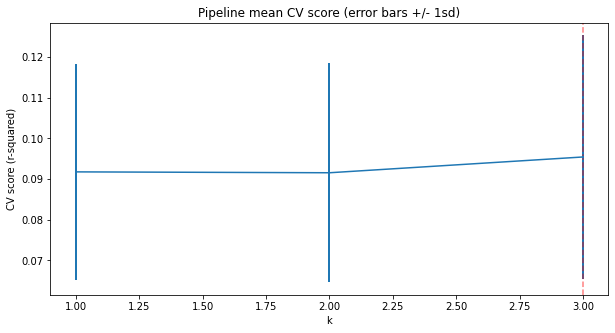

In [152]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From Player Ranking-Derived Features Metrics

#### R-squared (COD)

In [153]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.08080044, 0.12376427, 0.12796322, 0.09809056, 0.0465163 ])

In [154]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.09542695586369902, 0.029916195315898734)

#### Mean Absolute Error (MAE)

In [155]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [156]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.984647021742907, 0.24476609310903982)

In [157]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.986356728400548

#### Mean Squared Error (MSE)

In [158]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [159]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(38.8039148693715, 3.565013000868501)

In [160]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

39.36649320443168

#### Root Mean Square Error (RMSE)

In [161]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [162]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(6.222893736238111, 0.28197236896544103)

In [163]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

6.274272324694847

### Best Linear Model Feature Importance

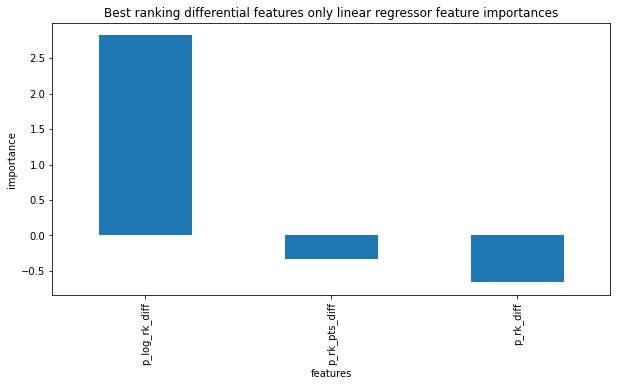

In [164]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'ranking_linearmodel_hard.pkl', modelpath)

### Save Prediction Metrics from Dummy and Ranking Data-Derived Linear Regression Models

In [ ]:
# # save other data for model comparisons in machine learning model stage
# comp_data_from4_ranking_hard = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_ranking_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_ranking_hard, f)

## Benchmark Linear Model Based on Aggregate Closing Line Data

### Train Test Split

In [165]:
len(df_model2) * .75, len(df_model2) * .25

(1809.0, 603.0)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df_model2.drop(columns='p_tot_pts_won%'), 
                                                    df_model2["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [167]:
y_train.shape, y_test.shape

((1809,), (603,))

In [168]:
y_train

1617     42.25
18612    62.50
13553    48.00
13774    58.49
23612    57.26
         ...  
13347    42.59
12305    45.25
40089    43.81
32896    47.56
18647    45.21
Name: p_tot_pts_won%, Length: 1809, dtype: float64

In [169]:
X_train.shape, X_test.shape

((1809, 1), (603, 1))

In [170]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 1617 to 18647
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p_AVG_C_IP  1804 non-null   float64
dtypes: float64(1)
memory usage: 28.3 KB


In [171]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [172]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [173]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [174]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [175]:
#Conduct grid search for this IWP-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000165C6890310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [176]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

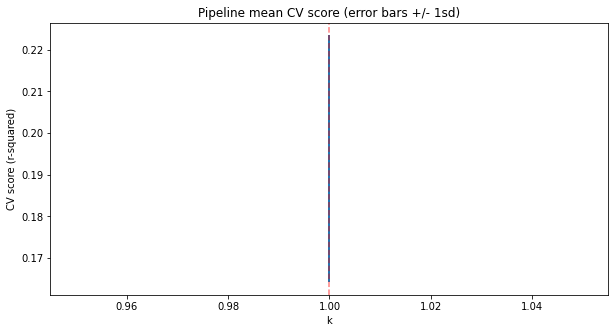

In [177]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Closing) Features Performance Metrics

#### R-squared (COD)

In [178]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.15198994, 0.21019904, 0.23845404, 0.19410104, 0.17427252])

In [179]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.19380331481421606, 0.029639184068929066)

#### Mean Absolute Error (MAE)

In [180]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [181]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.568816733171253, 0.21895569040334317)

In [182]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.6169997312953415

#### Mean Squared Error (MSE)

In [183]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [184]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(34.58795890906797, 3.2897672270368195)

In [185]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

35.381525237521465

#### Root Mean Square Error (RMSE)

In [186]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [187]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.874732803629078, 0.2747242163195748)

In [188]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.948237153772659

### Best Linear Model Feature Importance

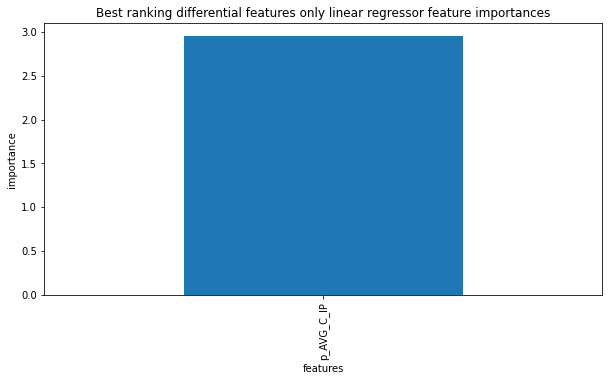

In [189]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_C_linearmodel_hard.pkl', modelpath)

### Save Prediction Metrics from IWP (Closing) Linear Regression Models

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_C_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_C, f)

## Benchmark Linear Model Based on Closing Line Data (Pinnacle Sports Only)

In [190]:
len(df_model3) * .75, len(df_model3) * .25

(1809.0, 603.0)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(df_model3.drop(columns='p_tot_pts_won%'), 
                                                    df_model3["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [192]:
y_train.shape, y_test.shape

((1809,), (603,))

In [193]:
y_train

1617     42.25
18612    62.50
13553    48.00
13774    58.49
23612    57.26
         ...  
13347    42.59
12305    45.25
40089    43.81
32896    47.56
18647    45.21
Name: p_tot_pts_won%, Length: 1809, dtype: float64

In [194]:
X_train.shape, X_test.shape

((1809, 1), (603, 1))

In [195]:
y_train

1617     42.25
18612    62.50
13553    48.00
13774    58.49
23612    57.26
         ...  
13347    42.59
12305    45.25
40089    43.81
32896    47.56
18647    45.21
Name: p_tot_pts_won%, Length: 1809, dtype: float64

In [196]:
X_train.shape, X_test.shape

((1809, 1), (603, 1))

In [197]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 1617 to 18647
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_PS_C_IP  1800 non-null   float64
dtypes: float64(1)
memory usage: 28.3 KB


In [198]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [199]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [200]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [201]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [202]:
#Conduct grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000165C6890310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [203]:
#Best params from grid search for this IWP-restricted (Pinnacle only closing lines) model. 
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

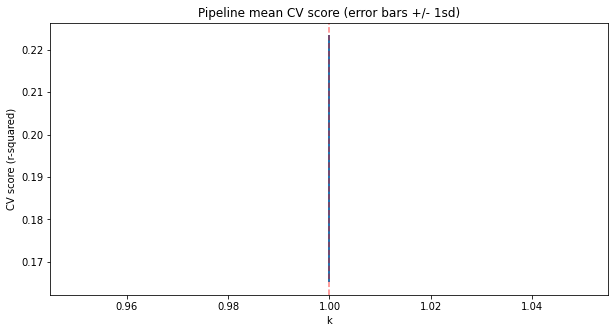

In [204]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Closing Lines) Features Performance Metrics

#### R-squared (COD)

In [205]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.15250544, 0.2071724 , 0.24031034, 0.19165416, 0.17972286])

In [206]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.19427303867453555, 0.029151073329879533)

#### Mean Absolute Error (MAE)

In [207]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [208]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.564386849741533, 0.22057077205350575)

In [209]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.6404483015535956

#### Mean Squared Error (MSE)

In [210]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [211]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.564386849741533, 0.22057077205350575)

In [212]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

35.502593876492966

#### Root Mean Square Error (RMSE)

In [213]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [214]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.8733525242170135, 0.2807485104217149)

In [215]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.95840531321032

### Best Linear Model Feature Importance

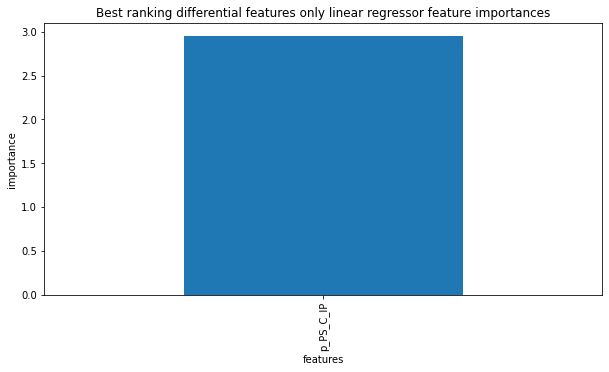

In [216]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_PINNY_C_linearmodel_hard.pkl', modelpath)

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_PINNY_C = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_PINNY_C_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_PINNY_C, f)

## Benchmark Linear Model Based on Opening Line Data (Pinnacle Sports Only)

### Train Test Split

In [217]:
len(df_model4) * .75, len(df_model4) * .25

(1809.0, 603.0)

In [218]:
X_train, X_test, y_train, y_test = train_test_split(df_model4.drop(columns='p_tot_pts_won%'), 
                                                    df_model4["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [219]:
y_train.shape, y_test.shape

((1809,), (603,))

In [220]:
y_train

1617     42.25
18612    62.50
13553    48.00
13774    58.49
23612    57.26
         ...  
13347    42.59
12305    45.25
40089    43.81
32896    47.56
18647    45.21
Name: p_tot_pts_won%, Length: 1809, dtype: float64

In [221]:
X_train.shape, X_test.shape

((1809, 1), (603, 1))

In [222]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1809 entries, 1617 to 18647
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   p_PS_O_IP  1800 non-null   float64
dtypes: float64(1)
memory usage: 28.3 KB


In [223]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [224]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [225]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [226]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [227]:
#Conduct grid search for this IWP-restricted (opening lines) model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000165C6890310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [228]:
#Best params from grid search for this IWP-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

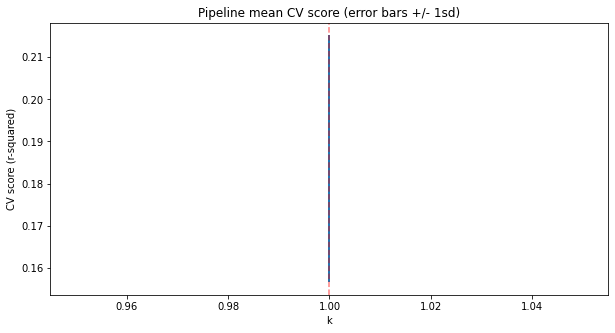

In [229]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From IWP (Pinnacle Opening Lines) Features Performance Metrics

#### R-squared (COD)

In [230]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.14728186, 0.19846253, 0.2316743 , 0.18930244, 0.16254777])

In [231]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.18585377976353917, 0.029330383088628998)

#### Mean Absolute Error (MAE)

In [232]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [233]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.581515419843169, 0.21886554259111476)

In [234]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.627081842142101

#### Mean Squared Error (MSE)

In [235]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [236]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(34.93876939507362, 3.423592074639796)

In [237]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

35.59860487230506

#### Root Mean Square Error (RMSE)

In [238]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [239]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.90406678404701, 0.2841914928114723)

In [240]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.966456642958621

### Best Linear Model Feature Importance

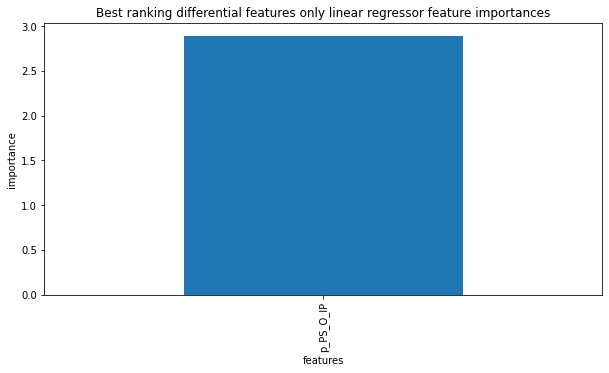

In [241]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [ ]:
# save the best linear model
# best_model = lr_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

# modelpath = '../models'
# save_file(best_model, 'IWP_PINNY_O_linearmodel_hard.pkl', modelpath)

In [ ]:
# save other data for model comparisons in machine learning model stage
# comp_data_from4_IWP_PINNY_O = (MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
# with open('../data/comp_data_from4_IWP_PINNY_O_hard.pickle', 'wb') as f:
#     pickle.dump(comp_data_from4_IWP_PINNY_O, f)

### Conclusions

So a simple linear model including only ranking and ranking derivative information outperformed the "dummy" model (RMSE,STD when applicable): 

First Round Removed
* Dummy Model: 6.59% Train; 6.79% Test
* Linear Model Using Ranking Data Only: 5.84% (.15%) Train; 6.15% Test
* Linear Model Using IWPs from Aggregate Closing Lines: 5.55% (.12%) Train; 5.78% Test
* Linear Model Using IWPs from Pinnacle Closing Lines: 5.55% (.12%) Train; 5.78% Test
* Linear Model Using IWPs from Pinnacle Opening Lines: 5.59% (.13%); 5.82% Test

First Round Only
* Dummy Model: 6.57% Train; 6.58% Test
* Linear Model Using Ranking Data Only: 6.22% (.28%) Train; 6.27% Test
* Linear Model Using IWPs from Aggregate Closing Lines: 5.87% (.27%) Train; 5.95% Test
* Linear Model Using IWPs from Pinnacle Closing Lines: 5.87% (.28%) Train; 5.96% Test
* Linear Model Using IWPs from Pinnacle Opening Lines: 5.90% (.28%); 5.97% Test